In [85]:
%%time
import os
import math
import scipy
import torch
import pandas as pd
import numpy as np
import matplotlib as plt
import pickle as pkl
import scipy.linalg as LA
import scipy.signal as ss
import warnings
warnings.filterwarnings("ignore")

from models import LSTMModel, LSTMModelWithMultiheadAttention, Model2, Model1, Model3
from utils import *
from weight import array_weight_vector
from doa import music

repo_dir = os.getcwd()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_signal = pd.read_csv(os.path.join(repo_dir,'data','input_signal_sample.csv'))

torch.__version__

CPU times: user 7.46 ms, sys: 0 ns, total: 7.46 ms
Wall time: 5.73 ms


'1.13.1'

In [86]:
import torch
import torch.nn as nn
import torch.nn.functional as F
class Model3(nn.Module):
    def __init__(self, input_size):
        super(Model3, self).__init__()
        self.linear1 = nn.Linear(input_size, 128)
        self.linear2 = nn.Linear(128, 256)
        self.linear3 = nn.Linear(256, 512)
        self.linear4 = nn.Linear(512, 512)
        self.linear5 = nn.Linear(512, 128)
  

    def forward(self, x):
        x = F.tanh(self.linear1(x))
        x = F.tanh(self.linear2(x))
        x = F.tanh(self.linear3(x))
        x = F.tanh(self.linear4(x))
        x = F.sigmoid(self.linear5(x))
        return x

### Simulation Setup

In [63]:
# %matplotlib notebook
show_path = True
color = {
    'bs':'g',
    'ris':'r',
    'ue':'b'
}
name = {
    'bs':'base-station',
    'ris':'RIS',
    'ue':'user-equipement'
}

### Antenna Weight Prediction

```html
.
├── azimuthal
│   ├── lstmattention
│   │   ├── head4
│   │   │   └── model_weights_best_192.pt
│   │   ├── head6
│   │   │   └── model_weights_best_199.pt
│   │   └── head8
│   │       └── model_weights_best_196.pt
│   ├── lstmmodel
│   │   └── model_weights_best_194.pt
│   ├── model1
│   │   └── model_weights_best_195.pt
│   ├── model2
│   │   ├── model_weights_best_200.pt
│   │   └── model_weights_best_93.pt
│   └── model3
│       └── model_weights_best_192.pt
├── azimuthal_position
│   ├── lstmattention
│   │   ├── head8
│   │   │   └── model_weights_best_198.pt
│   │   └── model_weights_best_180.pt
│   ├── lstmmodel
│   │   └── model_weights_best_198.pt
│   ├── model1
│   │   └── model_weights_best_195.pt
│   └── model2
│       └── model_weights_best_195.pt
├── model_weights_best_198.pt
├── model_weights_best_97.pt
└── position
    ├── lstmattention
    │   └── model_weights_best_200.pt
    ├── lstmmodel
    │   └── model_weights_best_97.pt
    ├── model1
    │   └── model_weights_best_190.pt
    └── model2
        └── model_weights_best_199.pt

```

In [120]:
# model = LSTMModel(input_size=2,
#                  hidden_size=576,
#                  num_layers=4,
#                  output_size=128)

# model = LSTMModelWithMultiheadAttention(input_size=3,
#                                         hidden_size=576, 
#                                         num_layers=4, 
#                                         output_size=128, 
#                                         num_heads=4)

model = Model2(input_size=6)

input_ = 'position'
model_name = 'model2'
weight_file = os.listdir(os.path.join(repo_dir,'model_states',input_, model_name))[0]
state = torch.load(os.path.join(repo_dir,'model_states',input_,model_name,weight_file), 
                   map_location=torch.device(device))

model.load_state_dict(state)
print(model.eval())

loc = 70
cols = [2,3,4,7,8,9] #range(10) #[0,1,5,6]#range(10)#[2,3,4,7,8,9] ##range(10) 
# position: [2,3,4,7,8,9] or angle: [0,1,5,6] or position+angle: range(10)

vector_check = True
angle_check = False
neural_network=True # make it false when using LSTM or related models

print('\ninput data\n----------')
print(input_signal.iloc[loc,cols])
input_array = input_signal.iloc[loc,cols].values
# input_array = np.array(input_array).reshape(1, 2, len(input_array)//2)
input_tensor = torch.tensor(input_array, dtype=torch.float32, device=device)

with torch.no_grad():
    output = model(input_tensor)
    
print("\ninput tensor shape:", input_tensor.shape)
print("output tensor shape:", output.shape)

Model2(
  (linear1): Linear(in_features=6, out_features=64, bias=True)
  (linear2): Linear(in_features=64, out_features=128, bias=True)
  (linear3): Linear(in_features=128, out_features=256, bias=True)
  (linear4): Linear(in_features=256, out_features=512, bias=True)
  (linear5): Linear(in_features=512, out_features=256, bias=True)
  (linear6): Linear(in_features=256, out_features=128, bias=True)
  (linear7): Linear(in_features=128, out_features=128, bias=True)
)

input data
----------
azimuth2    78.203795
x2           0.129326
y2           0.619254
azimuth1    75.630252
x1           0.000000
y1           0.000000
Name: 70, dtype: float64

input tensor shape: torch.Size([6])
output tensor shape: torch.Size([128])


**Taking limits [0,$\pi$/3] for *polar1* and [0,2$\pi$] for *azimuthal1*.
angle for first signal as `user equipment` signal direction.**


simulation sample data
----------------------
random signal direction #polar: [53.57160909 19.91878832]
random signal direction #azimuthal: [295.6424843   15.01078526]

base station locations: [0, 0, 0]

RIS 
direction vectors: [[0.006067509241204118, 2.7744162567926823e-05, 0.9999815921115096]]
direction angles: [[19.918788318070632, 15.010785261089966]]
power: [-1.75841946+0.64576634j]

user equipment 
direction vectors: [[0.016251992379168842, 0.0014675892375824373, 0.9998668505983872]]
direction angles: [[53.571609086160095, 295.64248430081943]]
power: [0.15402256-0.63575391j]


<IPython.core.display.Javascript object>


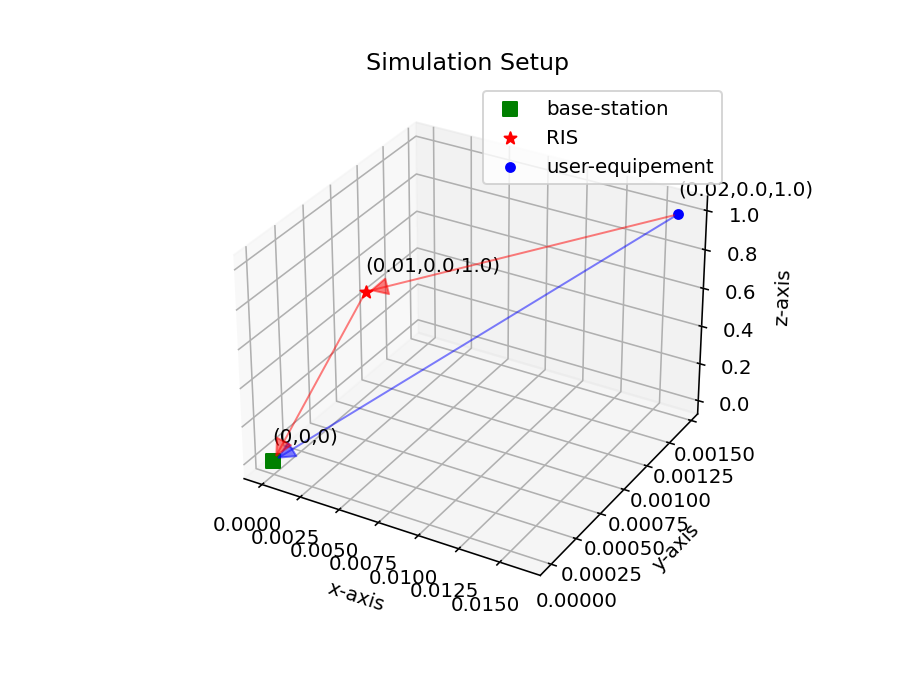

In [121]:
%matplotlib notebook
np.random.seed(6)

P,Q = 8,8 # rows and columns of antenna array
lamda = 1 # wavelength
ue = 1  # number of user equipments
ris = 1  # number of RIS
n_source = ue+ris
n_antenna = P*Q  # number of antenna elements 
snr = 10

print('\nsimulation sample data\n----------------------')
array = np.linspace(0,(n_antenna-1)/2,n_antenna)

# angle for RIS would be added
p_thetas = (np.pi/3)*(np.random.rand(n_source))   # random source polar directions
az_thetas = (2*np.pi)*(np.random.rand(n_source))   # random source azimuthal directions

ue_alphas = np.sqrt(1/2)*(np.random.randn(ue) + np.random.randn(ue)*1j) # random UE powers
ris_alphas = np.sqrt(1/2)*(np.random.randn(ris) + np.random.randn(ris)*1j) # random RIS powers

print('random signal direction #polar:',p_thetas*180/np.pi)
print('random signal direction #azimuthal:',az_thetas*180/np.pi)

ue_vectors, ris_vectors = [],[]
ue_angles, ris_angles = [], []
for polar,az in zip(p_thetas[:ue],az_thetas[:ue]):
    ue_vectors.append(find_position_vector(polar,az))
    ue_angles.append([polar*180/np.pi,az*180/np.pi])

for polar,az in zip(p_thetas[ue:],az_thetas[ue:]):
    ris_vectors.append(find_position_vector(polar,az))
    ris_angles.append([polar*180/np.pi,az*180/np.pi])

bs_vector = [0,0,0]
print('\nbase station locations:',bs_vector)
print(f'\nRIS \ndirection vectors: {ris_vectors}\ndirection angles: {ris_angles}\npower: {ris_alphas}')
print(f'\nuser equipment \ndirection vectors: {ue_vectors}\ndirection angles: {ue_angles}\npower: {ue_alphas}')

# visualizing the simulation setup
coordinates = {
    'bs':[[0],[0],[0]],
    'ris':np.transpose(ris_vectors).tolist(),
    'ue':np.transpose(ue_vectors).tolist()}

visualize_simulation(coordinates, color, name, show_path=True, precision=2, anno=True,shift=0.1)

In [122]:
numAngles = 360
p_angles = np.linspace(0,np.pi/3,numAngles)*180/np.pi
az_angles = np.linspace(0,2*np.pi,numAngles)*180/np.pi
general_angles = np.array(np.meshgrid(p_angles,az_angles)).T.reshape(-1, 2).tolist()
print('Total sample location collected:', len(general_angles))

Total sample location collected: 129600


### Covariance Matrix

In [123]:
numrealization = 100 # number of time samples collected at antenna array
H = np.zeros((n_antenna,numrealization)) + 1j*np.zeros((n_antenna,numrealization))
print('H matrix shape(n_antenna,time_instance):',H.shape)
antenna_weight = array_weight_vector(ris_vectors,
                                     ue_vectors,
                                     ris_angles,
                                     ue_angles,
                                     vector=vector_check,
                                     angle=angle_check,
                                     model=model,
                                     neural_network=neural_network) 

for iter in range(numrealization):
    # random distortions due to propagation medium
    #ris
    distortion_ris = np.exp(1j*2*np.pi*np.random.rand(1)) 
    recieved_power_ris = distortion_ris*ris_alphas*antenna_weight
    #ue
    distortion_ue = np.exp(1j*2*np.pi*np.random.rand(1))
    recieved_power_ue = distortion_ue*ue_alphas*antenna_weight
    
    net_recieved_power = recieved_power_ris+recieved_power_ue
    noise = np.sqrt(0.5/snr)*(np.random.randn(n_antenna)+np.random.randn(n_antenna)*1j)
    H[:,iter] = net_recieved_power+noise
CovMat = H@H.conj().transpose()
print('covariance matrix shape:',CovMat.shape)

H matrix shape(n_antenna,time_instance): (64, 100)
covariance matrix shape: (64, 64)


### Direction Of Arrival

In [124]:
%%time

# MUSIC algorithm
DoAsMUSIC, psindB = music(CovMat,
                          L = n_source,
                          N = n_antenna,
                          angles = general_angles,
                          ris_data = ris_angles+ris_vectors,
                          model = model,
                          vector_ = vector_check,
                          angle_ = angle_check,
                          height=[7, 9],
                          method='dl',
                          P=P,
                          Q=Q,
                          lamda=lamda,
                          neural_network=neural_network
                         )

Processing Angles:   0%|          | 0/129600 [00:00<?, ?it/s]

CPU times: user 3min 32s, sys: 1.64 s, total: 3min 34s
Wall time: 54.6 s


In [125]:
file_path = os.path.join(repo_dir,'data','lstmAV.pkl')
with open(file_path, 'wb') as file:
    pkl.dump(psindB, file)
    
with open(file_path, 'rb') as file:
    psindB = pkl.load(file)

<IPython.core.display.Javascript object>


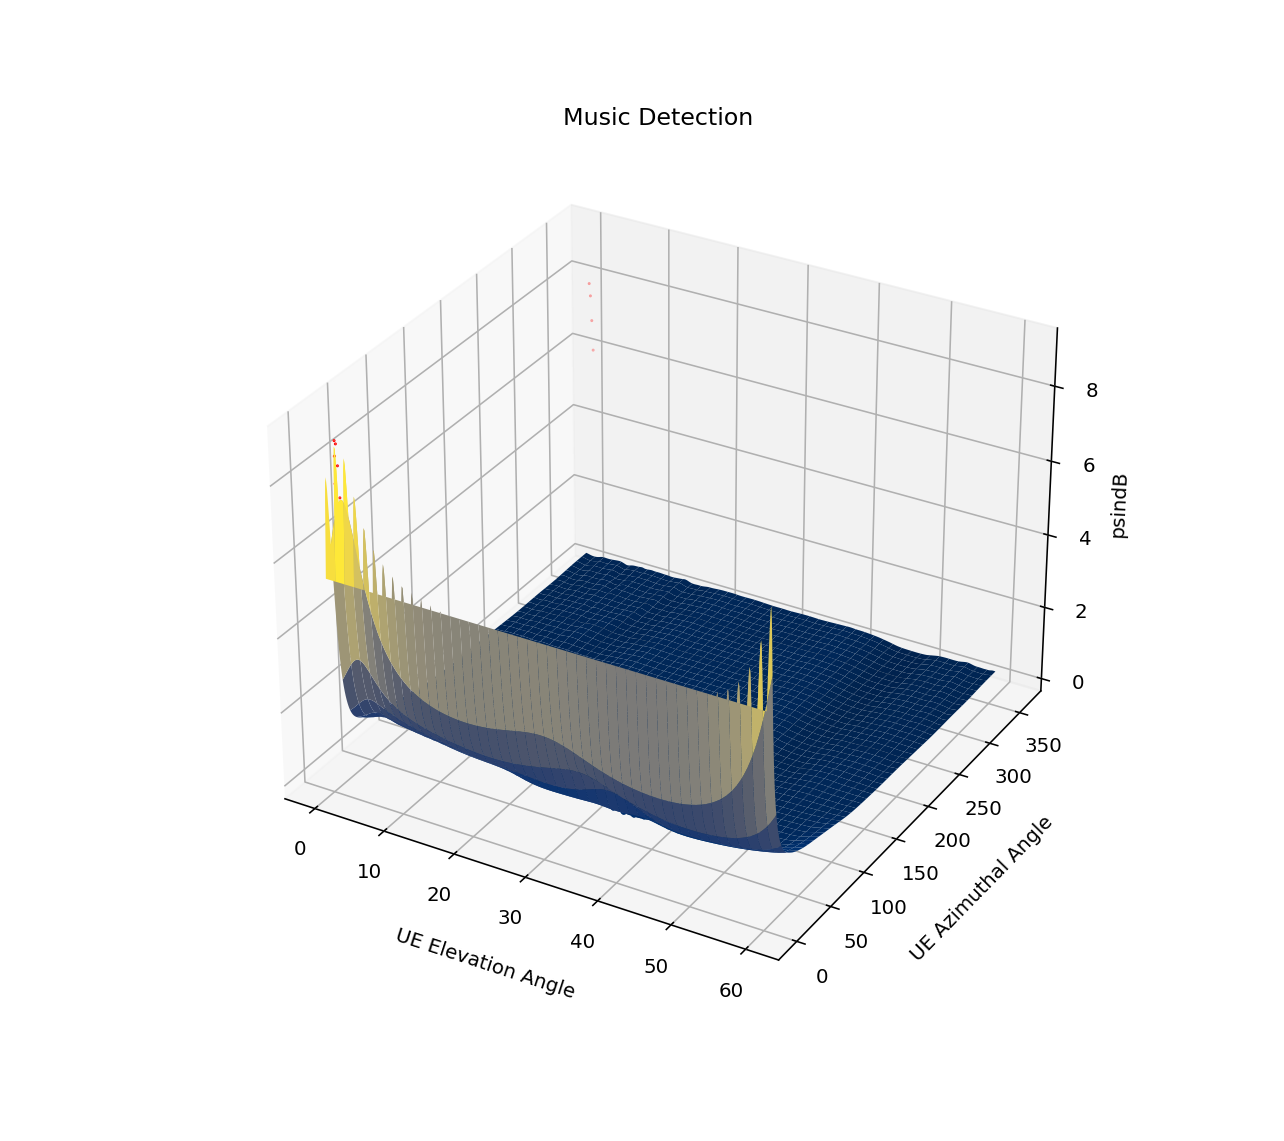

maximum psindB value: 8.898328496640284
peak reached at: [0.8356545961002785, 10.02785515320334]
actual UE direction: [[53.571609086160095, 295.64248430081943]]


In [126]:
# %matplotlib notebook
fig = plt.figure(figsize = (9,8))
ax = plt.axes(projection='3d')
# DoAsMUSIC,_= ss.find_peaks(psindB)
DoAsMUSIC,_ = ss.find_peaks(psindB, height=[6,9], distance=1.5)

X, Y = np.meshgrid(p_angles, az_angles)
Z = psindB[:129600].reshape(len(p_angles),len(p_angles))

surf = ax.plot_surface(X, Y, Z, cmap = plt.cm.cividis)

Xs = np.array(general_angles)[DoAsMUSIC][:,0]
Ys = np.array(general_angles)[DoAsMUSIC][:,1]
Zs = psindB[DoAsMUSIC]
ax.scatter(Xs,Ys,Zs,color='r',marker='.',s=1)

# Set axes label
ax.set_xlabel('UE Elevation Angle', labelpad=10)
ax.set_ylabel('UE Azimuthal Angle', labelpad=10)
ax.set_zlabel('psindB', labelpad=1)
ax.set_title("Music Detection")
print('maximum psindB value:',psindB[DoAsMUSIC].max())
print('peak reached at:',general_angles[DoAsMUSIC[np.argmax(psindB[DoAsMUSIC])]])
print('actual UE direction:',ue_angles)
# fig.colorbar(surf, shrink=0.5, aspect=8)
plt.show()

In [128]:
%%time
signal_samples = 10
indies = np.argsort(psindB[DoAsMUSIC])[-1*signal_samples:]
samples = np.array(general_angles)[DoAsMUSIC][indies]

# sinr = SINR(ris_alphas,ue_alphas,ris_data=ris_angles+ris_vectors,ue_angles=samples, snr=1)
sinr = SINR(ris_power = ris_alphas,
            ue_power = ue_alphas,
            ue_angles = samples,
            ris_data = ris_angles+ris_vectors,
            model = model,
            vector = vector_check,
            angle = angle_check,
            snr = 10,
            neural_network=neural_network)
detected_ue_angles = samples[np.argmax(sinr)].tolist()
print('detected angles for user equipment:',detected_ue_angles)
print('actual UE direction:',ue_angles)
print('with maximum SINR:',np.max(sinr))
print()

detected angles for user equipment: [0.8356545961002785, 360.0]
actual UE direction: [[53.571609086160095, 295.64248430081943]]
with maximum SINR: 20.022234202612385

CPU times: user 64.4 ms, sys: 0 ns, total: 64.4 ms
Wall time: 42.3 ms
